In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import torch
import torchvision
import torch.optim as optim
from torchvision import transforms
from torch.autograd import Variable
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image
from random import randint

In [2]:
epochs = 15
batch_size = 64
latent_code = 32   

image_size = int(64 * 64 * 3)
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)

data_path = '../anime-faces/data/'
transform = transforms.Compose(
    [
        transforms.Resize((64,64)), # resize images to same size
        torchvision.transforms.ToTensor(), # image to tensor
        transforms.Normalize(mean, std)
    ]
)

# dataset
dataset = torchvision.datasets.ImageFolder(
    root=data_path,
    transform=transform
)

# train test split
num_data = len(dataset)
ratio = .9
trainSet, testSet = torch.utils.data.random_split(dataset, [int(num_data*ratio), num_data-int(num_data*ratio)])
print("number of train data:", len(trainSet))
print("number of test data:", len(testSet))

# dataloader
trainLoader = torch.utils.data.DataLoader(
    trainSet,
    batch_size=batch_size,
    num_workers=0,
    shuffle=True
)
testLoader = torch.utils.data.DataLoader(
    testSet,
    batch_size=batch_size,
    num_workers=0,
    shuffle=True
)

batch = len(trainSet) / batch_size

number of train data: 19395
number of test data: 2156


In [7]:
# CNN VAE
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            Flatten()
        )
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)

        self.sigmoid = nn.Sigmoid()

        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [8]:
def UnNormalization(tensor):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
        print(s,m)
    return tensor

In [9]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, torch.sigmoid(x), size_average=False)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD*0, BCE, KLD

In [10]:
def compare(x):
    recon_x, _, _ = vae(x)
    return torch.cat([x, recon_x])

In [11]:
vae = VAE()
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

epochs = 100
save_interval = 200
loss_record = []

# sample
sample = Variable(torch.randn(batch_size, 32))

for epoch in range(epochs):
    train_loss = 0
    test_loss = 0

    # for training...
    for idx, (images, _) in enumerate(trainLoader):
        recon_images, mu, logvar = vae(images)
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        if idx % save_interval == 0:
            to_print = "Epoch[{}/{}] Loss: {:.3f} BCE: {:.3f} KL: {:.3f}".format(epoch+1, epochs, loss.item()/batch_size, bce.item()/batch_size, kld.item()/batch_size)
            print(to_print)

    sample_recon = vae.decoder(vae.fc3(sample).view(batch_size, 1024, 1, 1))
    save_image(sample_recon.data.view(batch_size, 3, 64, 64), './result/kl0/un_epoch_' +str(epoch) + '.png')
    print("Save samples finished...")
    
    # save record
    loss_record.append(train_loss/len(trainSet))
    
    to_print = "Epoch[{}/{}] Training Loss: {:.3f}".format(epoch+1,epochs, train_loss/len(trainSet))
    print(to_print)
    
    # for testing... 
    for idx, (images, _) in enumerate(testLoader):
        recon_images, mu, logvar = vae(images)
        loss, _, _ = loss_fn(recon_images, images, mu, logvar)
        test_loss += loss
    
    to_print = "Epoch[{}/{}] Testing Loss: {:.3f}".format(epoch+1,epochs, test_loss/len(testSet))
    print(to_print)
    
    # when epoch finishing...
    img = testSet[randint(1, 100)][0].unsqueeze(0)
    compare_img = compare(img)#*255
    save_image(compare_img.data, 'sample_kl_0_image.png')
    # display(Image('sample_image.png',width=700, unconfined=True))    
    print('-----------------------------------------------------')

.617 BCE: 8090.617 KL: 0.130
Epoch[24/100] Loss: 8090.071 BCE: 8090.071 KL: 0.133
Save samples finished...
Epoch[24/100] Training Loss: 8078.887
Epoch[24/100] Testing Loss: 8093.820
-----------------------------------------------------
Epoch[25/100] Loss: 8080.434 BCE: 8080.434 KL: 0.133
Epoch[25/100] Loss: 8089.700 BCE: 8089.700 KL: 0.131
Save samples finished...
Epoch[25/100] Training Loss: 8078.425
Epoch[25/100] Testing Loss: 8091.678
-----------------------------------------------------
Epoch[26/100] Loss: 8105.050 BCE: 8105.050 KL: 0.132
Epoch[26/100] Loss: 8100.022 BCE: 8100.022 KL: 0.132
Save samples finished...
Epoch[26/100] Training Loss: 8077.971
Epoch[26/100] Testing Loss: 8090.879
-----------------------------------------------------
Epoch[27/100] Loss: 8095.077 BCE: 8095.077 KL: 0.131
Epoch[27/100] Loss: 8071.630 BCE: 8071.630 KL: 0.131
Save samples finished...
Epoch[27/100] Training Loss: 8077.580
Epoch[27/100] Testing Loss: 8092.269
--------------------------------------

In [8]:
len(testSet[randint(1, 100)])

2

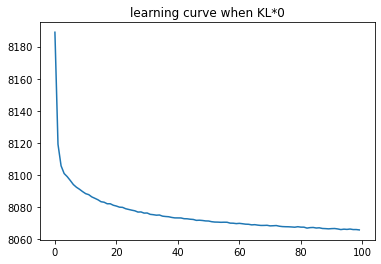

In [13]:
plt.plot(loss_record)
plt.title("learning curve when KL*0")
plt.show()